In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
from tools import *
from CONSTANT import *

signals = ['BVP', 'EDA', 'HR', 'TEMP']

In [4]:
wesad_path = r'./WESAD/WESAD/'
ppg_path = r'./PPGFieldStudyDataset/PPG_FieldStudy/'

In [5]:
# def extract_E4zip(folderpath):
#     for root, dir, files in os.walk(folderpath):
#         for file in files:
#             if '.zip' not in file and 'E4' not in file:
#                 continue
#             filename = os.path.join(root, file)
#             with zipfile.ZipFile(filename,"r") as zip_ref:
#                 zip_ref.extractall(filename.replace('.zip',''))
#     print(filename, 'done')

In [6]:
# extract_E4zip(wesad_path)
# extract_E4zip(ppg_path)

# get label

In [6]:
# label_file = r'./WESAD/WESAD/S10/S10_quest.csv'

def get_label(quest_file):
    labels = pd.read_csv(quest_file)
    conditions = labels.loc[0].values[0].replace('# ORDER;', '').replace(';bRead;fRead;sRead;;;;;;;;;;;;;;;;;;', '').split(';')
    starts = [float(t) * 60 for t in labels.iloc[1].values[0].split(';')[1:6]]
    ends = [float(t) * 60 for t in labels.iloc[2].values[0].split(';')[1:6]]
    va = [sc[0].replace('# DIM;', '')[:3].split(';') for sc in labels.iloc[16: 21].values]
    valence = [float(sc[0]) for sc in va]
    arousal = [float(sc[1]) for sc in va]
    return conditions, starts, ends, valence, arousal


In [7]:
subjects = ['S6', 'S9', 'S2', 'S13', 'S11', 'S10', 'S8', 'S14',
            'S15', 'S5', 'S17', 'S16', 'S3', 'S7', 'S4']

valences = []
arousals = []

for subject in subjects[:-2]:
    quest_file = os.path.join(wesad_path, subject, '{}_quest.csv'.format(subject))
    conditions, starts, ends, valence, arousal = get_label(quest_file)
    e4_path = os.path.join(wesad_path, subject, '{}_E4_Data'.format(subject))
    valences.extend(valence)
    arousals.extend(arousal)

In [14]:
win_size, step = 4, 2

signals = ['BVP']

sub_df = []
for signal_name in signals:
    signal_df = []
    raw_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format(signal_name))).iloc[2:, 0].values
    base_condition = raw_signal[int(starts[0]*SAMPLERATE[signal_name]): int(ends[0]*SAMPLERATE[signal_name])+1]
    baseline = base_condition.mean()
    for i in range(1, 5):
        condition_signal = raw_signal[int(starts[i]*SAMPLERATE[signal_name]): int(ends[i]*SAMPLERATE[signal_name])+1] - baseline
        signal = (condition_signal - condition_signal.min()) / (condition_signal.max() - condition_signal.min())
        condition = conditions[i]

        if signal_name == 'EDA':
            signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=100)
        elif signal_name in ['TEMP', 'BVP']:
            signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        elif signal_name == 'HR':
            # signal = chauvenet_filter(signal)
            # print(signal)
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        else:
            pass

        segments = np.array(segment_generator(signal, win_size=win_size*100, step=step*100))
        seg_cols = ['{}_seg{}'.format(signal_name, i) for i in range(segments.shape[1])]
        segment_df = pd.DataFrame(columns=seg_cols, data=segments)

        segment_df['segment_id'] = segment_df.index.tolist()
        segment_df['condition'] = condition
        segment_df['valence_rating'] = valence[i]
        segment_df['arousal_rating'] = arousal[i]
        segment_df['participant_id'] = subject

        signal_df.append(segment_df)

    # pd.concat(signal_df)

# pd.concat(sub_df, axis=1)

In [15]:
pd.concat(signal_df)

,BVP_seg0,BVP_seg1,BVP_seg2,BVP_seg3,BVP_seg4,BVP_seg5,BVP_seg6,BVP_seg7,BVP_seg8,BVP_seg9,...,BVP_seg395,BVP_seg396,BVP_seg397,BVP_seg398,BVP_seg399,segment_id,condition,valence_rating,arousal_rating,participant_id
0,0.002937,0.014161,0.033500,0.063276,0.107352,0.152852,0.196990,0.222848,0.235911,0.219927,...,0.000046,-0.000036,-0.000173,-0.000444,-0.000784,0,TSST,7.0,7.0,S3
1,0.004982,0.003213,0.001340,-0.000667,-0.002707,-0.004710,-0.006620,-0.008337,-0.009927,-0.011247,...,0.003116,0.003515,0.003891,0.004209,0.004496,1,TSST,7.0,7.0,S3
2,-0.001178,-0.001589,-0.001936,-0.002203,-0.002187,-0.001987,-0.001468,-0.000570,0.000533,0.001976,...,-0.044003,-0.043729,-0.042778,-0.040655,-0.038068,2,TSST,7.0,7.0,S3
3,0.004756,0.004983,0.005207,0.005429,0.005667,0.005913,0.006173,0.006434,0.006687,0.006909,...,-0.015994,-0.015846,-0.015527,-0.014826,-0.013914,3,TSST,7.0,7.0,S3
4,-0.035110,-0.031888,-0.028757,-0.025750,-0.023169,-0.020811,-0.018811,-0.017083,-0.015472,-0.013974,...,0.004047,0.004056,0.004063,0.004063,0.004067,4,TSST,7.0,7.0,S3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,0.012987,0.011972,0.009774,0.006846,0.002625,-0.002132,-0.007320,-0.012949,-0.018586,-0.024232,...,-0.008056,-0.008069,-0.007776,-0.007054,-0.005949,197,Medi 2,6.0,3.0,S3
198,0.033670,0.035068,0.036088,0.036828,0.036809,0.036239,0.035229,0.033293,0.031022,0.028319,...,-0.000042,0.000790,0.001291,0.001306,0.000818,198,Medi 2,6.0,3.0,S3
199,-0.004696,-0.003271,-0.001874,-0.000528,0.000528,0.001240,0.001681,0.001302,0.000553,-0.000677,...,-0.005630,-0.006337,-0.006180,-0.004745,-0.001938,199,Medi 2,6.0,3.0,S3
200,0.000124,-0.000832,-0.001830,-0.002828,-0.003674,-0.004319,-0.004805,-0.004786,-0.004510,-0.003900,...,-0.004074,-0.002730,-0.001612,-0.000844,-0.000605,200,Medi 2,6.0,3.0,S3


In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pd.set_option("display.max_info_columns", 1300)

import gc

%matplotlib inline

array([5.56666667, 4.89166667])

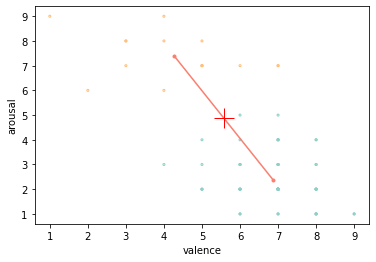

In [39]:
av_rating = pd.DataFrame()
av_rating['valence_rating'] = valences
av_rating['arousal_rating'] = arousals

colors = ["#8ECFC9", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
            facecolors='none', edgecolors=['#8ECFC9' if i==0 else '#FFBE7A' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='#FA7F6F', marker="o", markersize=3)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="+", markersize=20)
kmeans.cluster_centers_.sum(axis=0)/2

In [40]:
midpoint = kmeans.cluster_centers_.sum(axis=0)/2
av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
av_rating.head()

,valence_rating,arousal_rating,valence_label,arousal_label
0,8.0,2.0,1,0
1,6.0,3.0,1,0
2,6.0,2.0,1,0
3,8.0,2.0,1,0
4,8.0,1.0,1,0


In [41]:
av_rating['valence_label'].value_counts()

1    57
0    18
Name: valence_label, dtype: int64

In [44]:
av_rating['valence_rating'].value_counts()

7.0    27
8.0    14
6.0    14
5.0     9
4.0     4
3.0     3
9.0     2
2.0     1
1.0     1
Name: valence_rating, dtype: int64

In [43]:
av_rating['arousal_label'].value_counts()

0    58
1    17
Name: arousal_label, dtype: int64

# get E4

In [13]:
eda_file = r'./WESAD/WESAD/S10/S10_E4_Data/EDA.csv'
eda = pd.read_csv(eda_file)

In [14]:
eda_raw_signal = eda.iloc[2:].values

In [15]:
len(eda_raw_signal)

27287

# parse pkl

In [6]:
pkl_path = r'./WESAD/WESAD/S10/S10.pkl'

with open(pkl_path, 'rb') as file:
    s10_data = pickle.load(file, encoding='latin1')

In [10]:
len(s10_data['label'])

3847200